# FX Carry

This notebook analyses the FX carry trade (aka forward premium anomaly) where we long high-yielding currencies against low-yielding ones. The uncovered interest rate parity (UIP) suggests that higher-yielding currencies should depreciate on average to offset the benefit of higher interest rates. Empirically however that those currencies tended to weaken much less (or even appreciate) than what the UIP predicts. The FX carry strategy tries to exploit this phenomenon by creating a long-short portfolio in the FX market.

In [1]:
from datetime import datetime
import logging
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import pytz
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
plt.style.use('bmh')

from vivace.backtest import signal
from vivace.backtest import processing
from vivace.backtest.engine import BacktestEngine
from vivace.backtest.stats import Performance
from vivace.enums import Strategy

# Performance
## Run backtest

The `engine` instance below implements a FX carry backtest using FX futures listed on CME. Currencies used in the backtest are EUR, JPY, GBP, CAD, AUD and NZD. Carry is defined as
$$
Carry_t = {\rm log} \left( \frac{F_{1, t}}{F_{2, t}} \right) \cdot annualisationFactor
$$
where $F_{1, t}$ is the 1st contract price, $F_{2, t}$ is the 2nd contract price and $annualisationFactor$ is  4 as futures contracts are rolled quarterly to make sure we have prices for both 1st and 2nd contracts on a given day.

The backtest always invests in the front contract and hence the formula above is not technically measuring the carry associated with invested contracts. On the other hand, this can alleviate the issue of potentially using asynchronous prices (settle prices are used to calculate carry) and as long as futures curve is close to linear, it should provide a gooe approximation of carry.

Once instruments are ranked by the $Carry$, it goes long top 33% (i.e., 2 instruments at max) and short bottom 33%. Positions are adjusted on a monthly basis.

In [2]:
engine = BacktestEngine(
    strategy=Strategy.DELTA_ONE.value,
    instrument=['EC', 'JY', 'BP', 'CD', 'AD', 'ZB'],
    signal=signal.XSCarryFutureFuture(),
    log_level=logging.WARN,
)
engine.run()

In [3]:
portfolio_return = (engine.calculate_equity_curve(calculate_net=False)
                    .rename('FX carry portfoliot'))

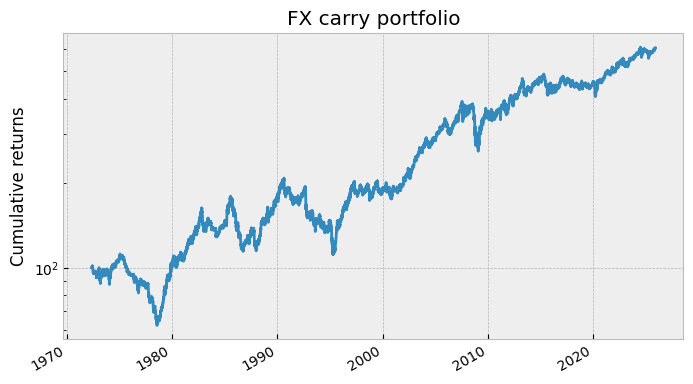

In [4]:
fig, ax = plt.subplots(figsize=(8, 4.5))
portfolio_return.plot(ax=ax, logy=True);
ax.set_title('FX carry portfolio')
ax.set_ylabel('Cumulative returns');

In [5]:
portfolio_return.pipe(Performance).summary()

,FX carry portfoliot
CAGR,0.033577
Annualised vol,0.110442
Sharpe ratio,0.304026
Max drawdown,0.466063
Calmar ratio,0.072044
Skewness,-0.599541
Kurtosis,7.621427
Worst return,-0.090426
Worst 1d return,-0.090426
Worst 1w return,-0.113948


## Recent performance

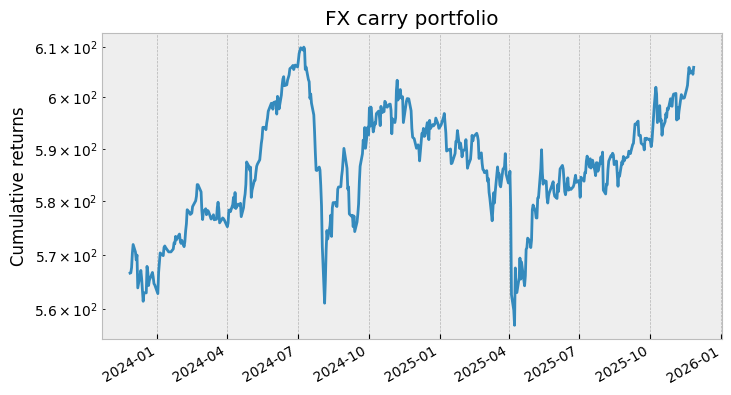

In [6]:
fig, ax = plt.subplots(figsize=(8, 4.5))
portfolio_return.tail(252 * 2).plot(ax=ax, logy=True);
ax.set_title('FX carry portfolio')
ax.set_ylabel('Cumulative returns');

## Carry
As can be seen below, carry dispersion in developed market is shrunk significantly recently which explains the weak performance of fx carry trade.

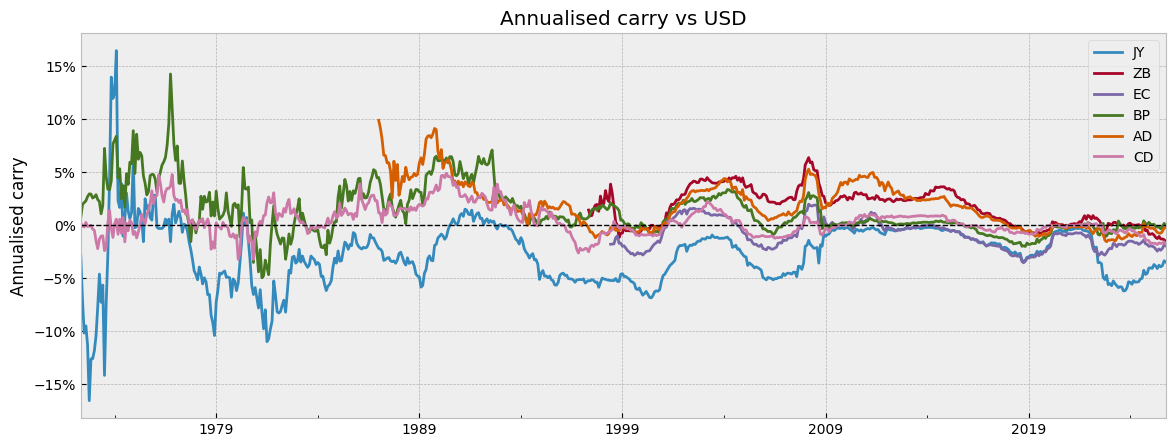

In [7]:
fig, ax = plt.subplots(figsize=(14, 5))
engine.pipeline.pipeline[0].carry.asfreq('m', method='pad').plot(ax=ax)
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1, decimals=0))
ax.axhline(0, color='black', lw=1, ls='--')
ax.set_ylabel('Annualised carry')
ax.set_title('Annualised carry vs USD');

# Reference

- Deutsche Bank, 2009, db Currency Return.
- Koijen, R.S., Moskowitz, T.J., Pedersen, L.H. and Vrugt, E.B., 2018. Carry. Journal of Financial Economics, 127(2), pp.197-225.

In [8]:
print(f'Updated: {datetime.now(pytz.utc).strftime("%d-%b-%Y %H:%M")}')

Updated: 01-Dec-2025 23:29
